# 4. Categorical Model
Author: _Carlos Sevilla Salcedo (Updated: 18/07/2019)_

This notebook presents the categorical approach of the algorithm. for our model we understand that the view we are analysing is composed of one among several categories (The data given to the model must be an integer). To do so, we have to use the graphic model shown in the next image modifying the relation between the variables $X$ and $t$. 
<img src="Images/Graphic_Model_Categorical.png" style="max-width:100%; width: 70%">
where, in this case, variable $t$ is now a vector instead of a matrix.

In order to have this relationship we have stablished a multinomial probit function as the connection between them, as proposed by _Girolami (2016)_.


## Synthetic data generation

We can now generate data in a similar manner to the regression model to compare the performance of both apporaches. In this case we are going to change the regression data to a categorical approach, to work with classes.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(0)

N = 1000  # number of samples
D0 = 55  # input features
D1 = 3   # output features

myKc = 20

K = 2       # common latent variables
K0 = 3      # first view's latent variables
K1 = 3      # second view's latent variables
Kc=K+K0+K1  # latent variables

# Generation of matrix W
A0 = np.random.normal(0.0, 1, D0 * K).reshape(D0, K)
A1 = np.random.normal(0.0, 1, D1 * K).reshape(D1, K)

B0 = np.random.normal(0.0, 1, D0 * K0).reshape(D0, K0)
B1 = np.random.normal(0.0, 1, D1 * K1).reshape(D1, K1)

W0 = np.hstack((np.hstack((A0,B0)),np.zeros((D0,K1))))
W1 = np.hstack((np.hstack((A1,np.zeros((D1,K0)))),B1))
W_tot = np.vstack((W0,W1))

# Generation of matrix Z
Z = np.random.normal(0.0, 1, Kc * N).reshape(N, Kc)

# Generation of matrix X
X0 = np.dot(Z,W0.T) + np.random.normal(0.0, 0.1, D0 * N).reshape(N, D0)
X1 = np.dot(Z,W1.T) + np.random.normal(0.0, 0.1, D1 * N).reshape(N, D1)
    
# Generation of matrix t
t1 = np.argmax(X1,axis=1)

Once the data is generated we divide it into train and test in order to be able to test the performance of the model. After that, we can normalize the data.

In [2]:
from sklearn.model_selection import train_test_split
X_tr, X_tst, Y_tr, Y_tst = train_test_split(X0, t1, test_size=0.3, random_state = 31)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)

## Training the model

Once the data is prepared we just have to feed it to the model. As the model has so many possibilities we have decided to pass the data to the model following a particular structure so that we can now, for each view, if the data corresponds to real, multilabel or categorical as well as knowing if we want to calculate the model with sparsity in the features.



In [3]:
import os
os.sys.path.append('lib')
import sshiba

In [4]:
myKc = 20            # number of latent features
max_it = int(5*1e4)  # maximum number of iterations
tol = 1e-6           # tolerance of the stopping condition (abs(1 - L[-2]/L[-1]) < tol)
prune = 1            # whether to prune the irrelevant latent features

myModel = sshiba.SSHIBA(myKc, prune)
X0_tr = myModel.struct_data(X_tr, 0, 0)
X1_tr = myModel.struct_data(Y_tr, 1, 0)
X0_tst = myModel.struct_data(X_tst, 0, 0)
X1_tst = myModel.struct_data(Y_tst, 1, 0)
myModel.fit(X0_tr, X1_tr, max_iter = max_it, tol = tol, Y_tst = X1_tst, X_tst = X0_tst, AUC = 1)
print('Final AUC %.3f' %(myModel.AUC[-1]))

Iteration 698 Lower Bound 155067.3 K   20
Model correctly trained. Convergence achieved
Final L(Q):    155067.3
Final AUC 0.686


## Visualization of the results

### Lower Bound and MSE

Now the model is trained we can plot the evolution of the lower bound through out the iterations. This lower bound is calculated using the values of the variables the model is calculating and is the value we are maximizing. As we want to maximize this value it has to be always increasing with each iteration.

At the same time, we are plotting now the evolution of the Minimum Square Error (MSE) with each update of the model. As we are not minimizing this curve, this doesn't necessarily have to be always decreasing and might need more iterations to reach a minimum. 

In [5]:
def plot_AUC(AUC):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(AUC, linewidth=2, marker='s',markersize=5, label='SSHIBA', markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Multiclass AUC')
    plt.legend()

def plot_L(L):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(L, linewidth=2, marker='s',markersize=5, markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('L(Q)')


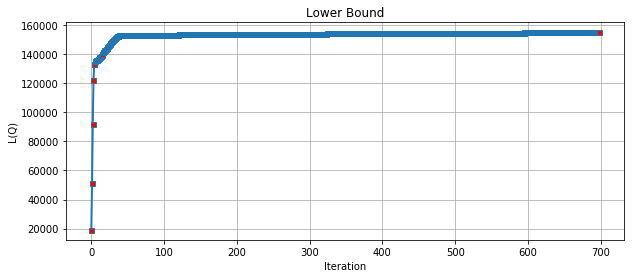

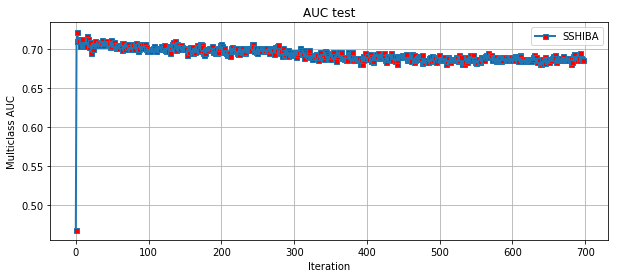

In [6]:
plot_L(myModel.L)
plt.title('Lower Bound')

plot_AUC(myModel.AUC)
plt.title('AUC test')
plt.show()

## LFW Dataset

In order to improve the analysis of the results, we are showing in this section the results obtained using the _LFW_ database. This database is composed by different images of famous people and the goal is to identify what person each of them is. For the purpose of this example we have included the images of the people with more images, having that our data is now composed of 7 people or categories.

First of all, we can prepare the data we want to work with.

In [11]:
import pickle

resize = 0.4
    
my_dict = pickle.load( open('Databases/data_lfwa_'+str(resize)+'_7classes.pkl', "rb" ), encoding='latin1' )

X = my_dict['X'].astype(float)
Y = (my_dict['Y_cat']).astype(int)
h = my_dict['h']
w = my_dict['w']
target_names = my_dict['target']
from sklearn.model_selection import train_test_split
X_tr, X_tst, Y_tr, Y_tst = train_test_split(X, Y.astype(int), test_size=0.3, random_state = 31)

n_samples = X.shape[0]
n_features = X.shape[1]
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1277
n_features: 2400
n_classes: 7


Here we can see what the images we have downloaded look like.

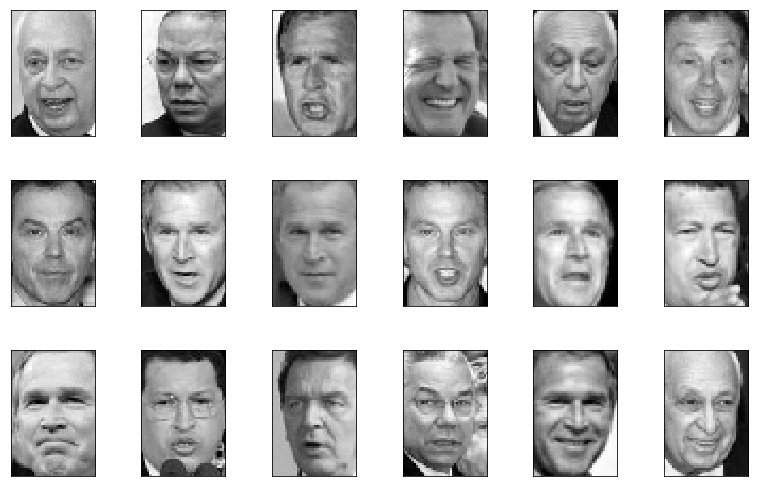

In [51]:
n_col, n_row = 6,3
plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(X_tst[i,:].reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(())

At this point, the model can be trained with the train and test splits.

In [57]:
myKc = 50            # number of latent features
max_it = int(5*1e4)  # maximum number of iterations
tol = 1e-7           # tolerance of the stopping condition (abs(1 - L[-2]/L[-1]) < tol)
prune = 1            # whether to prune the irrelevant latent features

myModel = sshiba.SSHIBA(myKc, prune)
X0_tr = myModel.struct_data(X_tr, 0, 0)
X1_tr = myModel.struct_data(Y_tr, 1, 0)
X0_tst = myModel.struct_data(X_tst, 0, 0)
X1_tst = myModel.struct_data(Y_tst, 1, 0)
myModel.fit(X0_tr, X1_tr, max_iter = max_it, tol = tol, Y_tst = X1_tst, X_tst = X0_tst, AUC = 1)
print('Final AUC %.3f' %(myModel.AUC[-1]))

Iteration 85 Lower Bound -5430854.2 K   50
Model correctly trained. Convergence achieved
Final L(Q):    -5430854.2
Final AUC 0.873


Now the model is trained, we can visualize the results, seeing how the image look like as well as both the true and predicted label for each one of them.

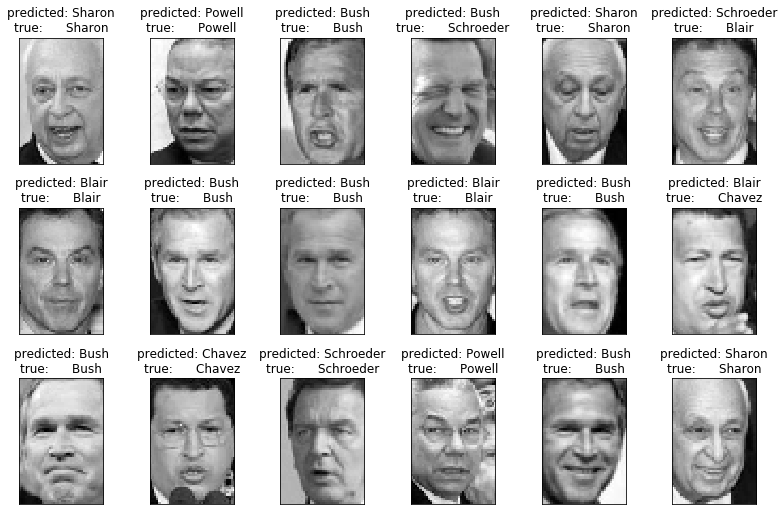

In [59]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

def plot_W(W):
    plt.figure()
    plt.imshow((np.abs(W)), aspect=W.shape[1]/W.shape[0])
    plt.colorbar()
    plt.title('W')
    plt.ylabel('features')
    plt.xlabel('K')
    
y_pred = myModel.predict([0],1,0, X0_tst)

prediction_titles = [title(y_pred, Y_tst, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_tst, prediction_titles, h, w)

## LFW Dataset with Sparsity

Finally, we can use the sparse version of the method to make the model learn not only which latent features are relevant but also which features are the more relevant as well in order to learn the labels given.

To do so, we just need to train the model as we did before, specifying which views are to be learned with the before mentioned sparsity.

In [29]:
myKc = 50            # number of latent features
max_it = int(5*1e4)  # maximum number of iterations
tol = 1e-7           # tolerance of the stopping condition (abs(1 - L[-2]/L[-1]) < tol)
prune = 1            # whether to prune the irrelevant latent features

myModel = sshiba.SSHIBA(myKc, prune)
X0_tr = myModel.struct_data(X_tr, 0, 1)
X1_tr = myModel.struct_data(Y_tr, 1, 0)
X0_tst = myModel.struct_data(X_tst, 0, 1)
X1_tst = myModel.struct_data(Y_tst, 1, 0)
myModel.fit(X0_tr, X1_tr, max_iter = max_it, tol = tol, Y_tst = X1_tst, X_tst = X0_tst, AUC = 1)
print('Final AUC %.3f' %(myModel.AUC[-1]))

Iteration 1454 Lower Bound -5299483.1 K   50
Model correctly trained. Convergence achieved
Final L(Q):    -5299483.1
Final AUC 0.880


In [33]:
import pickle
my_dict = {}
my_dict['models'] = myModel

filename = 'Models_categorical_sparse'
with open(filename+'.pkl', 'wb') as output:
    pickle.dump(my_dict, output, pickle.HIGHEST_PROTOCOL)

In [34]:
import pickle
filename = 'Models_categorical_sparse'
my_dict = pickle.load( open( filename+'.pkl', "rb" ))
myModel = my_dict['models']


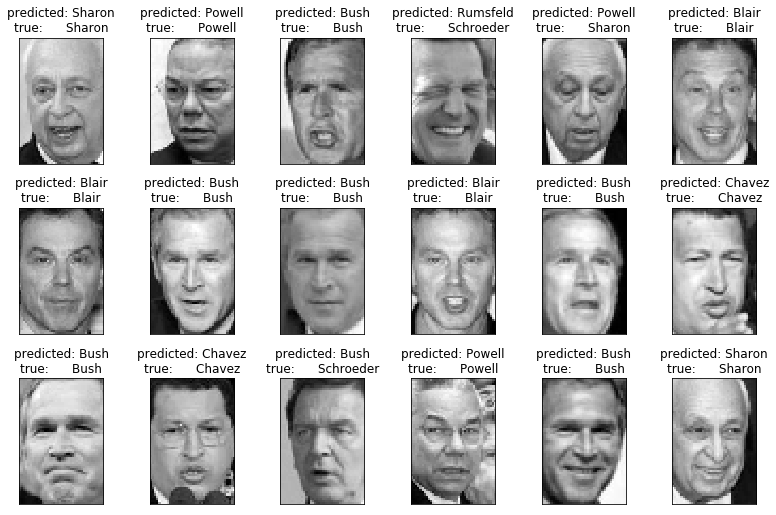

In [35]:
y_pred = myModel.predict([0],1,0, X0_tst)

prediction_titles = [title(y_pred, Y_tst, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_tst, prediction_titles, h, w)

## Visualization of the results

### Vector $\gamma$
Once the model is trained, we can visualize the variable $\gamma$ to see which parts of the image are considered as relevant and which ones irrelevant.

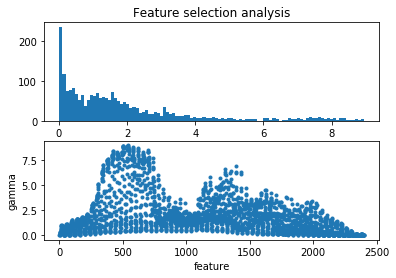

In [36]:
q = myModel.q_dist
gamma = q.gamma_mean(0)

ax1 = plt.subplot(2, 1, 1)
plt.title('Feature selection analysis')
plt.hist(gamma,100)
ax2 = plt.subplot(2, 1, 2)
plt.plot(gamma,'.')
plt.ylabel('gamma')
plt.xlabel('feature')
plt.show()

### Matrix $W$

Now we can see as we did in the _sparse notebook_ how the model is learning matrix $W$ to trasnform $X$ to the latent space, $Z$.

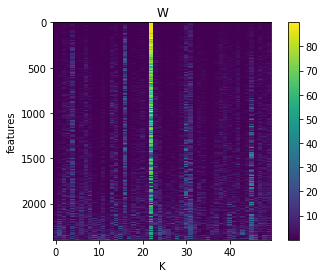

In [37]:
pos_ord_var=np.argsort(gamma)[::-1]
plot_W(q.W[0]['mean'][pos_ord_var,:])

### Vector $\gamma$ mask visualization

Finally, as the data we are working with are images, we could visualize the values the variable $\gamma$ takes as an image to see the relevance each pixel has.
In our case, we can see that the method is capable of finding the most relevant features to describe the different attributes we have as labels.

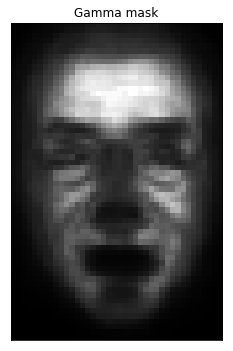

In [38]:
q = myModel.q_dist
gamma = q.gamma_mean(0)

plt.figure(figsize=(3, 5))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
plt.imshow(gamma.reshape((h, w)), cmap=plt.cm.gray)
plt.xticks(())
plt.yticks(())
plt.title('Gamma mask')
plt.show()

### Matrix $W$ masks visualization

Conversely, we can plot the projection matrix W to see the how the latent features are learning the different parts of face learning.

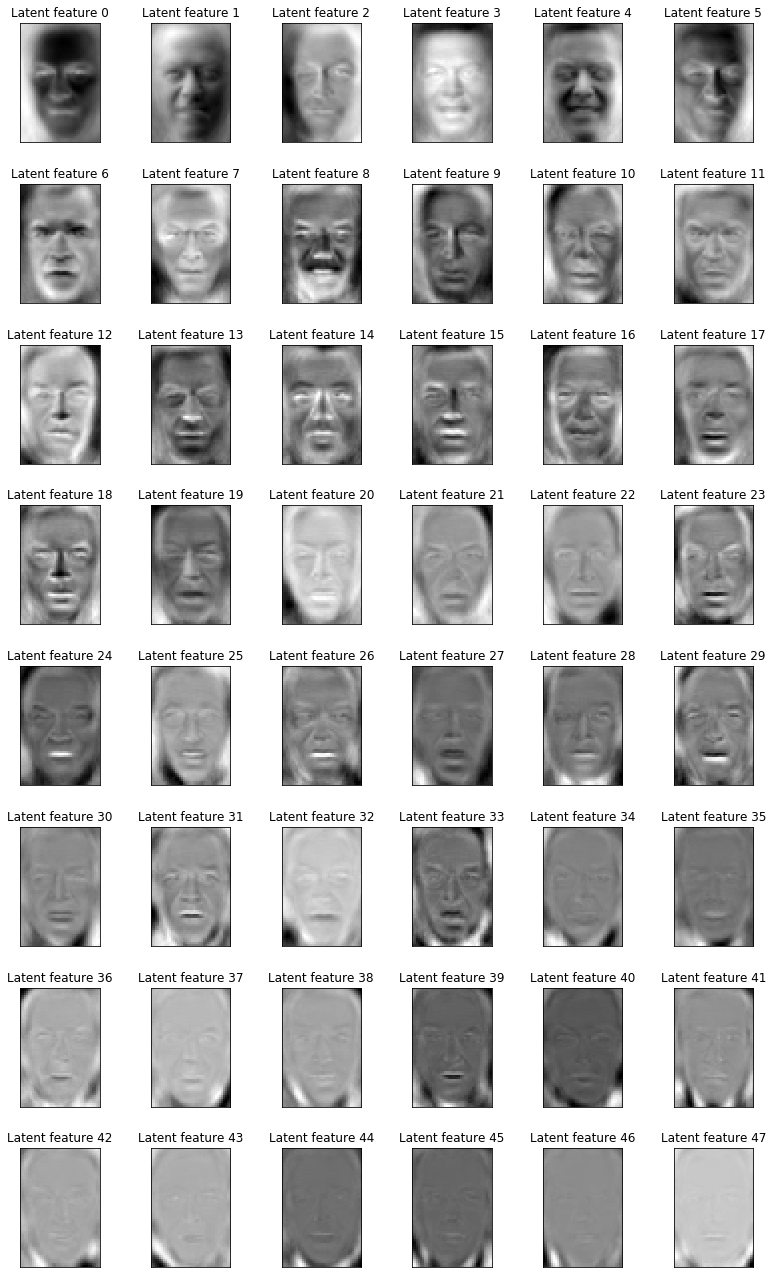

In [39]:
alpha = q.alpha_mean(0)
pos_ord_var = np.argsort(alpha)
W_0 = q.W[0]['mean'][:,pos_ord_var]

Wface_titles = ["Latent feature %d" % i for i in range(W_0.shape[0])]
n_col, n_row = 6,8
plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(W_0[:,i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(Wface_titles[i], size=12)
    plt.xticks(())
    plt.yticks(())
plt.show()